обрали тестувальний сет як 10% від кількосьі вибірки

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics

from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf
from statsmodels.stats.stattools import durbin_watson
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error

from scipy.stats import jarque_bera
from sklearn.metrics import r2_score
import warnings

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('fivethirtyeight')

lags=60
precent_train_set = 0.9
rolling_value = 10


In [2]:
file1 = open('ATS_Lab_04_new/data/RSAFSNA.txt')
file_text_1 = file1.read()
y = np.array([float(x) for x in file_text_1.split()])

In [3]:
date = np.array('1992-02', dtype=np.datetime64)
date = date + np.arange(len(y))

In [4]:
df_y = pd.DataFrame({'Date': date, 'Value':y})
df_y = df_y.set_index('Date')

#### <a href='https://www.bounteous.com/insights/2020/09/15/forecasting-time-series-model-using-python-part-one/'> Source <a/>

## Visualizate the data

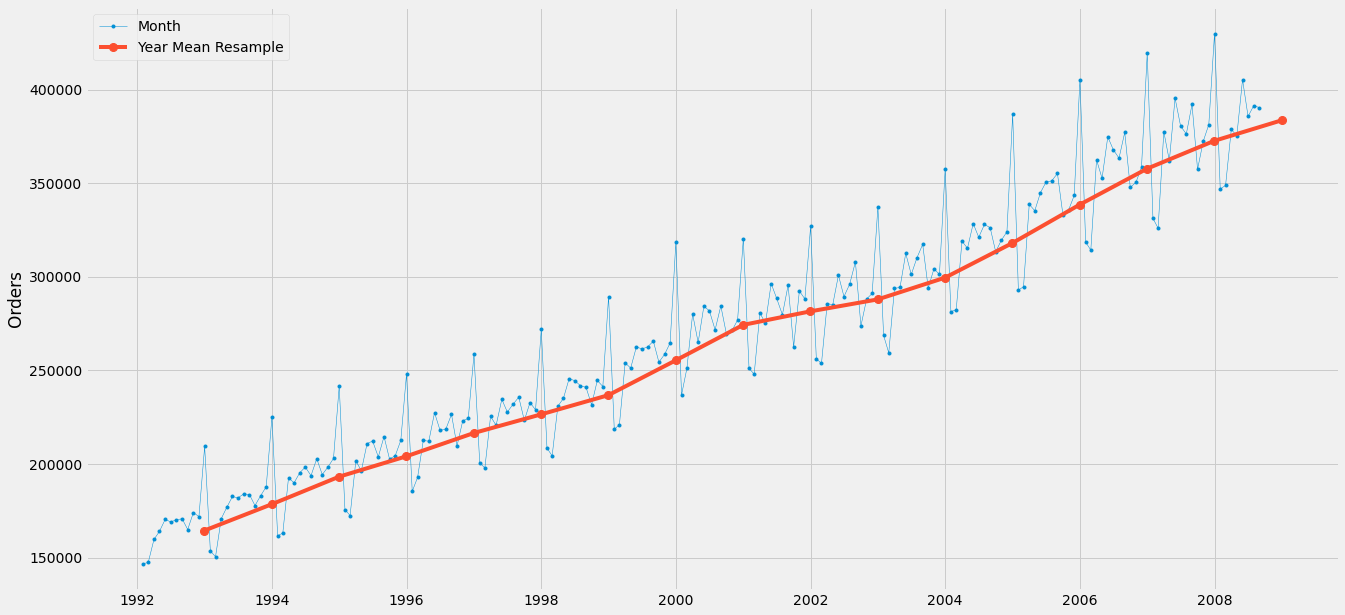

In [5]:
y = df_y
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(y,marker='.', linestyle='-', linewidth=0.5, label='Month')
ax.plot(y.resample('Y').mean(),marker='o', markersize=8, linestyle='-', label='Year Mean Resample')
ax.set_ylabel('Orders')
ax.legend();

## Decomposing the Data

In [6]:
import statsmodels.api as sm

def seasonal_decompose (y):
    decomposition = sm.tsa.seasonal_decompose(y, model='additive',extrapolate_trend='freq')
    fig = decomposition.plot()
    fig.set_size_inches(14,7)
    plt.show()

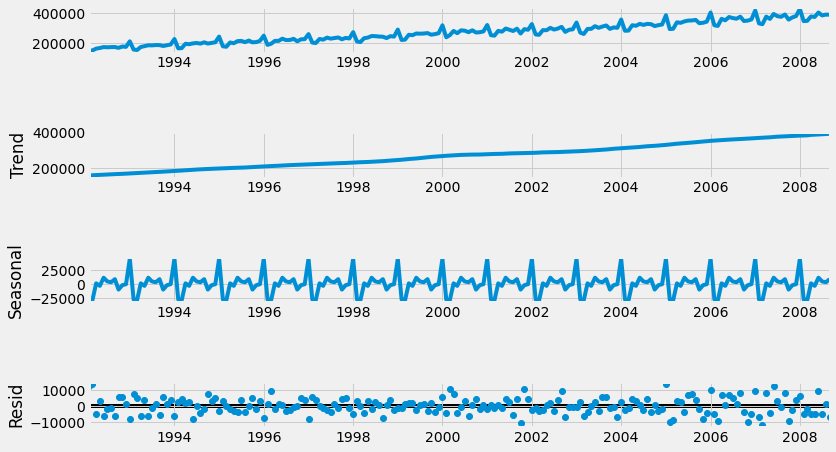

In [7]:
seasonal_decompose(df_y)

## Checking Stationarity

In [8]:
### plot for Rolling Statistic for testing Stationarity
def test_stationarity(timeseries, title):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=rolling_value).mean() 
    rolstd = pd.Series(timeseries).rolling(window=rolling_value).std()
    
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(timeseries, label= title)
    ax.plot(rolmean, label='rolling mean');
    ax.plot(rolstd, label='rolling std (x10)');
    ax.legend()

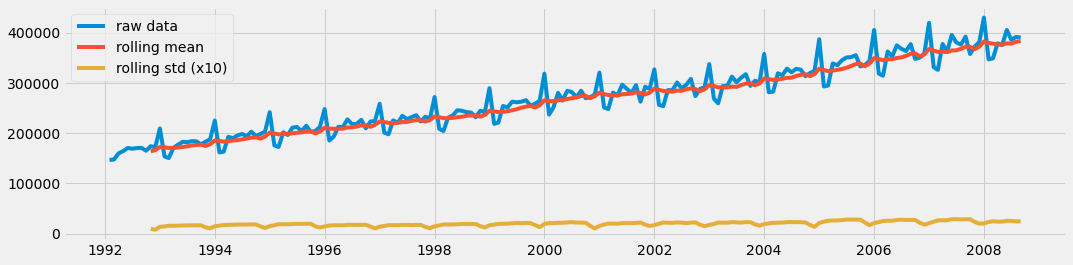

In [9]:
pd.options.display.float_format = '{:.8f}'.format
test_stationarity(y.Value,'raw data')

## Augmented Dickey-Fuller Test

In [10]:
# Augmented Dickey-Fuller Test
from statsmodels.tsa.stattools import adfuller

def ADF_test(timeseries, dataDesc):
    print(' > Is the {} stationary ?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))

In [11]:
ADF_test(y,'raw data')

 > Is the raw data stationary ?
Test statistic = -0.026
P-value = 0.956
Critical values :
	1%: -3.4662005731940853 - The data is not stationary with 99% confidence
	5%: -2.8772932777920364 - The data is not stationary with 95% confidence
	10%: -2.575167750182615 - The data is not stationary with 90% confidence


## Detrending

 > Is the de-trended data stationary ?
Test statistic = -2.248
P-value = 0.189
Critical values :
	1%: -3.4680615871598537 - The data is not stationary with 99% confidence
	5%: -2.8781061899535128 - The data is not stationary with 95% confidence
	10%: -2.5756015922004134 - The data is not stationary with 90% confidence


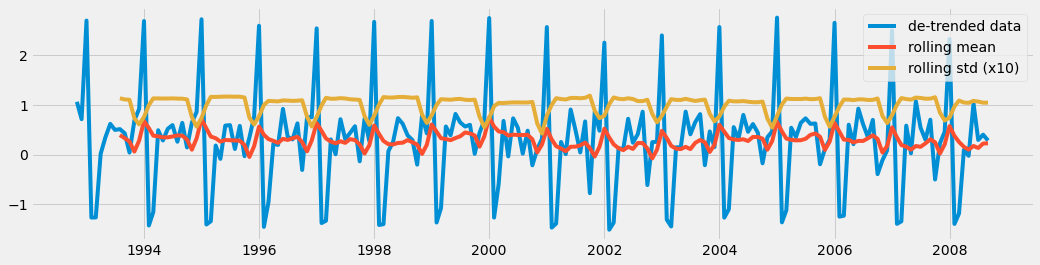

In [12]:
# Detrending
y_detrend =  (y - y.rolling(window=rolling_value).mean())/y.rolling(window=rolling_value).std()

test_stationarity(y_detrend.Value,'de-trended data')
ADF_test(y_detrend,'de-trended data')

## Differencing

 > Is the 1 lag differenced data stationary ?
Test statistic = -3.171
P-value = 0.022
Critical values :
	1%: -3.4662005731940853 - The data is not stationary with 99% confidence
	5%: -2.8772932777920364 - The data is  stationary with 95% confidence
	10%: -2.575167750182615 - The data is  stationary with 90% confidence


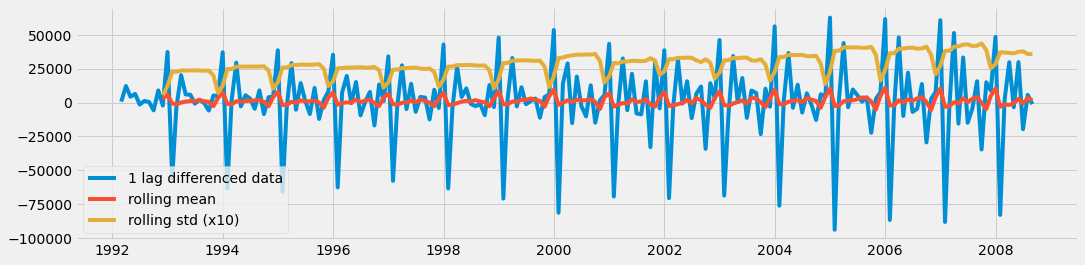

In [13]:
# Differencing
diff_model = 1
y_10lag =  y - y.shift(diff_model)

test_stationarity(y_10lag.Value,f'{diff_model} lag differenced data')
ADF_test(y_10lag,f'{diff_model} lag differenced data')

## Combining Detrending and Differencing


 > Is the 1 lag differenced de-trended data stationary ?
Test statistic = -5.426
P-value = 0.000
Critical values :
	1%: -3.4680615871598537 - The data is  stationary with 99% confidence
	5%: -2.8781061899535128 - The data is  stationary with 95% confidence
	10%: -2.5756015922004134 - The data is  stationary with 90% confidence


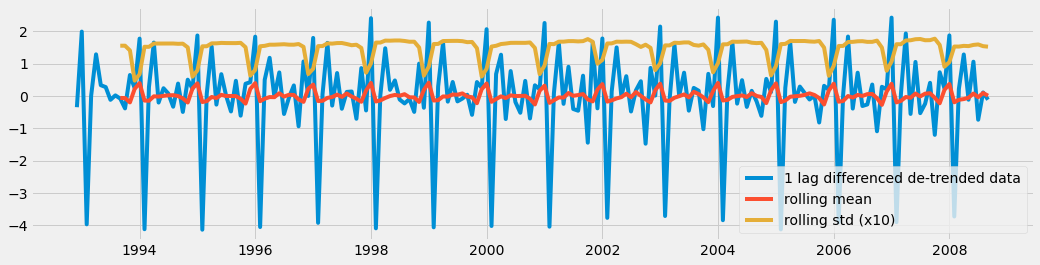

In [14]:
y_10lag_detrend =  y_detrend - y_detrend.shift(diff_model)

test_stationarity(y_10lag_detrend.Value,f'{diff_model} lag differenced de-trended data')
ADF_test(y_10lag_detrend.Value,f'{diff_model} lag differenced de-trended data')

## Create Training & Testing Datasets


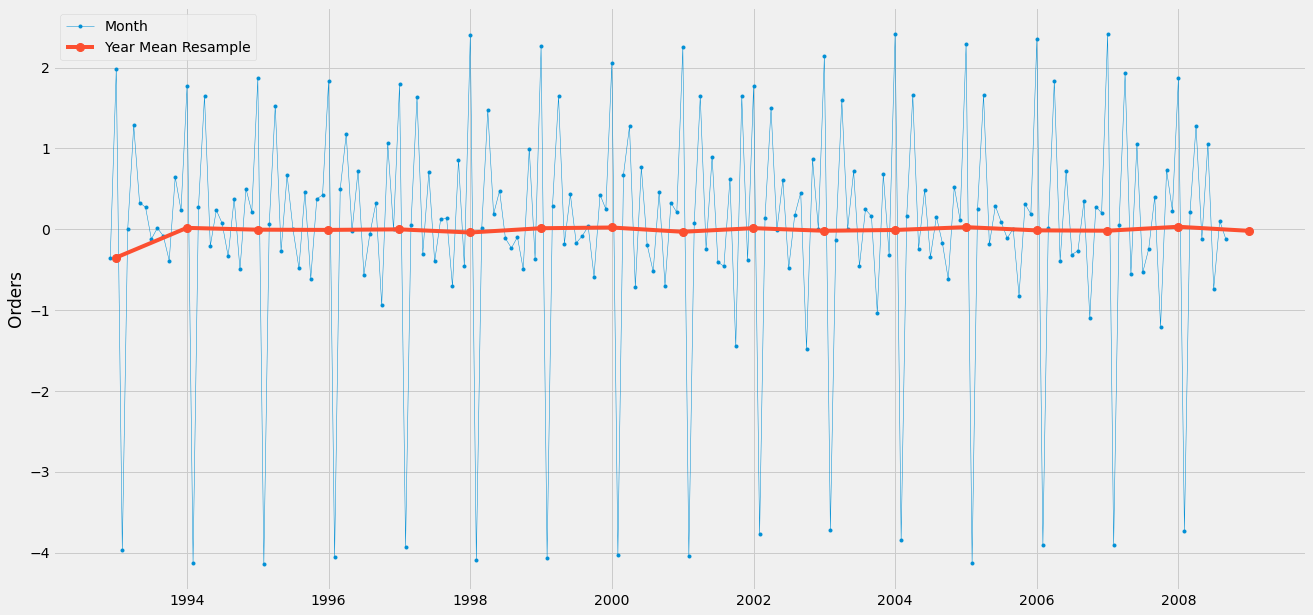

In [15]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(y_10lag_detrend,marker='.', linestyle='-', linewidth=0.5, label='Month')
ax.plot(y_10lag_detrend.resample('Y').mean(),marker='o', markersize=8, linestyle='-', label='Year Mean Resample')
ax.set_ylabel('Orders')
ax.legend();

In [16]:
def calculate_metrics_sample(y):
   
    print('yes')
    sample = pd.Series(y)
    
    y_dict = {}

    y_dict['series'] = 'Y'
    y_dict['observations'] = sample.size
    y_dict['mode'] = sample.mode()[0]
    y_dict['mean'] = sample.mean()
    y_dict['median'] = sample.median()
    y_dict['variation'] = sample.var()
    y_dict['skewness'] = sample.skew()
    y_dict['kurtosis'] = sample.kurt()
    y_dict['jarque-bera'] = jarque_bera(sample).statistic
    y_dict['probability'] = jarque_bera(sample).pvalue
    
    return pd.DataFrame(np.array([[metr] for metr in y_dict.values()]).T, 
                        columns=['series', 'observations', 'mode','mean','median',
                                 'variation','skewness','kurtosis','jarque-bera','probability'])#,'params_ar','params_intercept'])

#### <a href='https://www.bounteous.com/insights/2020/09/15/forecasting-time-series-model-using-python-part-two/'> Source 2</a>

In [17]:
def show_plots(y):
    sample = pd.Series(y)
    plt.figure(figsize=(20,6))
    plt.title('Sample')
    plt.xlabel('k')
    plt.ylabel('y')
    plt.plot(sample, marker='o')
    plt.grid(True)
    plt.show();
    
    plot_pacf(sample, lags=lags);
    plot_acf(sample, lags=lags);

# Metrics

In [18]:
columns =['name', 'r2', 'RMSE','MAE','sum_squared_resid','AIC','durbin_watson','theil_index']

models_metrics_static = pd.DataFrame(columns=columns)
models_metrics_static_test = pd.DataFrame(columns=columns)

calculate_metrics_sample(y.Value)

yes


,series,observations,mode,mean,median,variation,skewness,kurtosis,jarque-bera,probability
0,Y,200,146737.0,268831.08,264861.0,4655234022.07397,0.22007611501127924,-0.8901924464689346,8.309463126688069,0.015690002336133824


In [19]:
y_10lag_detrend

,Value
Date,
1992-02-01,nan
1992-03-01,nan
1992-04-01,nan
1992-05-01,nan
1992-06-01,nan
...,...
2008-05-01,-0.11848186
2008-06-01,1.05680777
2008-07-01,-0.73737247


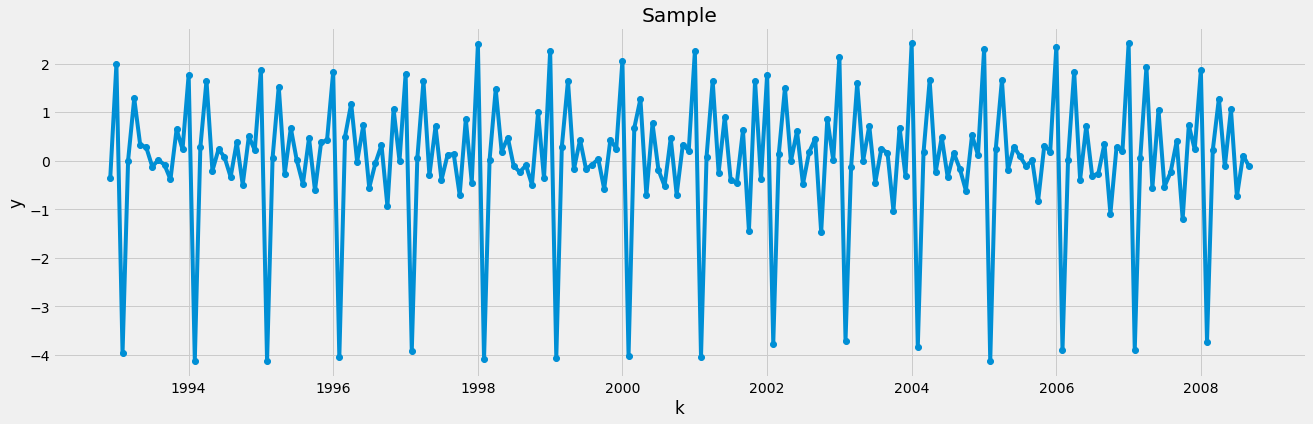

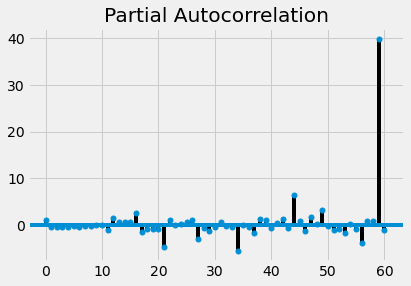

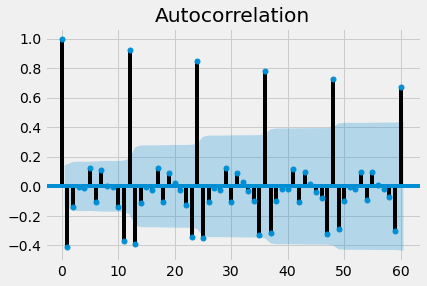

In [20]:
show_plots(y_10lag_detrend.Value.dropna())
# plot_pacf(y_10lag, lags=lags);
# plot_acf(y_10lag, lags=lags);

## Fitting ARIMA Model

In [21]:
def AR(p, df, test=True):
    df_temp = df
    
    #Generating the lagged p terms
    for i in range(1,p+1):
        df_temp[f'Shifted_values_{i}'] = df_temp['Value'].shift(i)
    
    train_size = (int)(precent_train_set * df_temp.shape[0])

    #Breaking data set into test and training
    df_train = pd.DataFrame(df_temp[0:train_size])
    df_test = pd.DataFrame(df_temp[train_size:df.shape[0]])

    df_train_2 = df_train.dropna()

    #X contains the lagged values ,hence we skip the first column
    X_train = df_train_2.iloc[:,1:].values.reshape(-1,p)

    #Y contains the value,it is the first column
    y_train = df_train_2.iloc[:,0].values.reshape(-1,1)

    lr = LinearRegression()
    lr.fit(X_train,y_train)

    theta  = lr.coef_.T
    intercept = lr.intercept_
    df_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_

    X_test = df_test.iloc[:,1:].values.reshape(-1,p)
    df_test['Predicted_Values'] = X_test.dot(lr.coef_.T) + lr.intercept_

    RMSE = np.sqrt(mean_squared_error(df_test['Value'], df_test['Predicted_Values']))

    return df_train_2,df_test,theta.reshape((len(theta),)),intercept[0],RMSE

In [22]:
def claculate_metrics_model(y, y_pred, name, count_parameters):
    return pd.DataFrame({'name':[name],
                              'r2':[r2_score(y, y_pred)],
                              'RMSE':[np.sqrt(mean_squared_error(y, y_pred))],
                              'MAE':[mean_absolute_error(y, y_pred)],
                              'sum_squared_resid':[np.sum((y - y_pred)**2)],
                              'AIC':[len(y) * np.log(np.sum((y - y_pred)**2) / len(y)) + 2*count_parameters],
                              'durbin_watson': [durbin_watson(y - y_pred)],
                        'theil_index':[np.sqrt((1/len(y_pred))*np.sum((y-y_pred)**2))
                                      / (np.sqrt((1/len(y))*np.sum(y**2)) + np.sqrt((1/len(y_pred))*np.sum(y_pred**2)))],
                        }
        )

## Choosing parameters for AR model

In [23]:
models_metrics_ar = pd.DataFrame(columns=columns)

best_RMSE = 1e15
best_p = -1

for i in range(1, 50):
    df_train, df_test, theta, intercept, RMSE = AR(i, pd.DataFrame(y_10lag_detrend.Value))
    metric = claculate_metrics_model(df_test.Value, df_test.Predicted_Values, f'AR({i})', i)
    models_metrics_ar = models_metrics_ar.append(metric)
        
    if RMSE < best_RMSE:
        best_RMSE = RMSE
        best_p = i
        
print(f'best_p:\t{best_p}')

best_p:	35


In [24]:
models_metrics_ar

,name,r2,RMSE,MAE,sum_squared_resid,AIC,durbin_watson,theil_index
0,AR(1),0.20078102,1.31791920,0.98732488,34.73822047,13.04216523,1.77719744,0.62006824
0,AR(2),0.36401306,1.17565526,0.84668903,27.64330581,10.47302641,1.67754303,0.50988227
0,AR(3),0.43067938,1.11233178,0.83380188,24.74563990,10.25834068,1.88892766,0.46789758
0,AR(4),0.54146792,0.99825330,0.78388025,19.93019304,7.93007093,1.63457081,0.40199574
0,AR(5),0.55764662,0.98048413,0.80486530,19.22698244,9.21164708,1.68649514,0.39101475
0,AR(6),0.61724094,0.91204997,0.72845927,16.63670294,8.31758003,1.52359580,0.35482821
0,AR(7),0.62258268,0.90566337,0.69703699,16.40452273,10.03649599,1.46668245,0.35215067
0,AR(8),0.62437238,0.90351351,0.69507140,16.32673330,11.94143141,1.40357497,0.34968014
0,AR(9),0.64172350,0.88239909,0.71301358,15.57256320,12.99556646,1.41879181,0.34047880
0,AR(10),0.63806147,0.88689724,0.71695003,15.73173429,15.19895383,1.31138523,0.34296981


In [25]:
best_p_arima = 12
df_train_lag,df_test_lag,theta_ar_lag,intercept_ar_lag,RMSE = AR(best_p_arima,pd.DataFrame(y_10lag_detrend.Value))

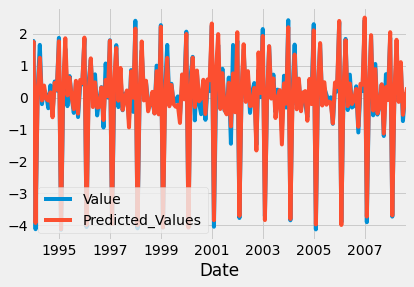

In [26]:
df_c_arima = pd.concat([df_train_lag,df_test_lag])
df_c_arima[['Value','Predicted_Values']].plot()

In [27]:
def MA(q, res):
    
    for i in range(1,q+1):
         res[f'Shifted_values_{i}'] = res['Residuals'].shift(i)

    train_size = (int)(precent_train_set * res.shape[0])

    res_train = pd.DataFrame(res[0:train_size])
    res_test = pd.DataFrame(res[train_size:res.shape[0]])

    res_train_2 = res_train.dropna()
    X_train = res_train_2.iloc[:,1:].values.reshape(-1,q)
    y_train = res_train_2.iloc[:,0].values.reshape(-1,1)

    lr = LinearRegression()
    lr.fit(X_train,y_train)

    theta  = lr.coef_.T
    intercept = lr.intercept_
    res_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_

    X_test = res_test.iloc[:,1:].values.reshape(-1,q)
    res_test['Predicted_Values'] = X_test.dot(lr.coef_.T) + lr.intercept_
#     res_test[['Residuals','Predicted_Values']].plot()

    RMSE = np.sqrt(mean_squared_error(res_test['Residuals'], res_test['Predicted_Values']))

#     print("The RMSE is :", RMSE,", Value of q : ",q)
    return [res_train_2,res_test,theta.reshape((len(theta),)),intercept[0],RMSE]

In [28]:
res = pd.DataFrame()
res['Residuals'] = df_c_arima.Value - df_c_arima.Predicted_Values

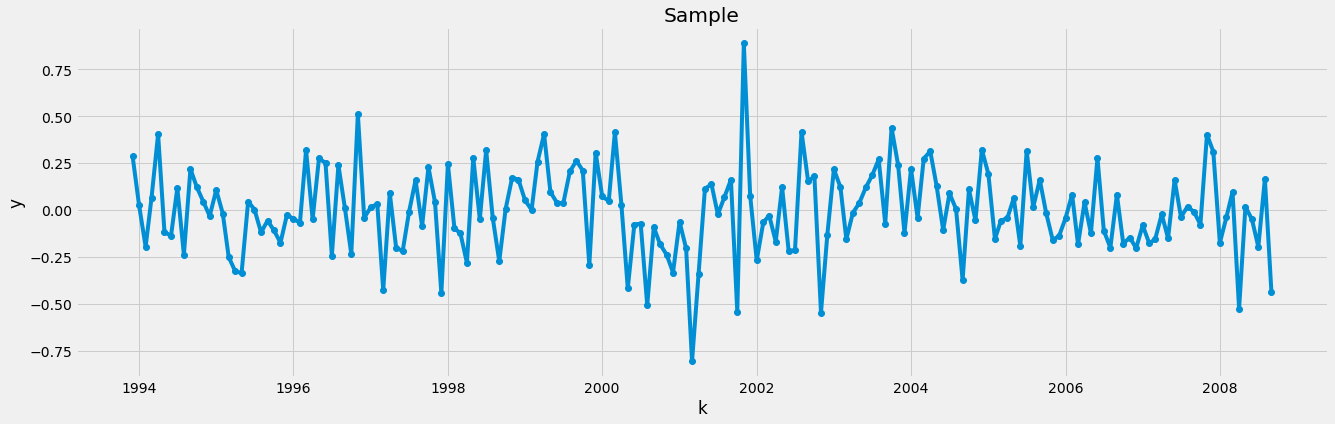

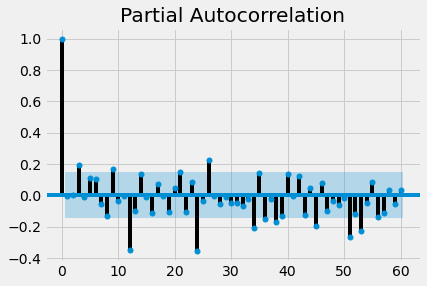

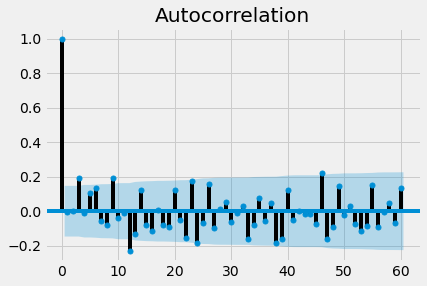

In [29]:
show_plots(res.Residuals.dropna())

## Choosing parameters for MA model

In [30]:
models_metrics_ma = pd.DataFrame(columns=columns)


best_RMSE=100000000000
best_q = -1

for i in range(1,50):
    
    res_train, res_test,theta,intercept,RMSE = MA(i,pd.DataFrame(res.Residuals))
    metric = claculate_metrics_model(res_test.Residuals, res_test.Predicted_Values, f'MA({i})', i)
    models_metrics_ma = models_metrics_ma.append(metric)
    
    
    if(RMSE<best_RMSE):
        best_RMSE = RMSE
        best_q = i

In [31]:
print(f'best_q:\t {best_q}')

best_q:	 26


In [32]:
models_metrics_ma

,name,r2,RMSE,MAE,sum_squared_resid,AIC,durbin_watson,theil_index
0,MA(1),-0.01846081,0.22289590,0.16065719,0.89428651,-52.03781495,2.12696253,0.97877255
0,MA(2),-0.01812143,0.22285876,0.16063439,0.89398851,-50.04381398,2.12455479,0.97856535
0,MA(3),0.05812365,0.21435167,0.15588419,0.82703950,-49.44494253,1.99862977,0.82521045
0,MA(4),0.04908802,0.21537738,0.15611897,0.83497347,-47.27308743,2.00432674,0.82850760
0,MA(5),0.08241123,0.21156994,0.14957687,0.80571314,-45.91518667,1.97188093,0.79407249
0,MA(6),0.05727811,0.21444786,0.15468651,0.82778194,-43.42879089,1.88131502,0.78216243
0,MA(7),0.06784867,0.21324219,0.15408633,0.81850019,-41.63176145,1.89424072,0.77543122
0,MA(8),0.07494185,0.21242931,0.15100292,0.81227183,-39.76925580,1.92726229,0.75357350
0,MA(9),0.02558899,0.21802235,0.14453713,0.85560742,-36.83367698,1.76245749,0.77092951
0,MA(10),0.02902070,0.21763809,0.14441433,0.85259411,-34.89718192,1.77580473,0.77120355


In [33]:
best_q_arima=24
res_train_lag,res_test_lag,theta_ma_lag,intercept_ma_lag,RMSE = MA(best_q_arima,pd.DataFrame(res.Residuals))
# print(f'theta: {theta}')
# print(f'intercept: {intercept}')

In [34]:
res_c_lag = pd.concat([res_train_lag,res_test_lag])
df_c_arima.Predicted_Values += res_c_lag.Predicted_Values

## Plot before come back to real value

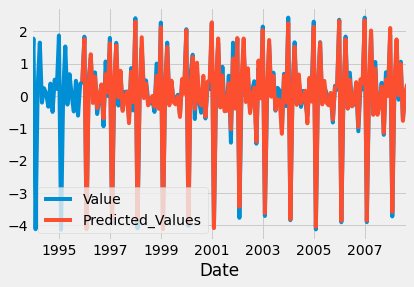

In [35]:
df_c_arima[['Value','Predicted_Values']].plot()

In [36]:
df_c_arima.Predicted_Values += y_detrend.shift(diff_model).Value
df_c_arima.Predicted_Values *= y.rolling(window=rolling_value).std().Value
df_c_arima.Predicted_Values += y.rolling(window=rolling_value).mean().Value


df_c_arima.Value += y_detrend.shift(diff_model).Value
df_c_arima.Value *= y.rolling(window=rolling_value).std().Value
df_c_arima.Value += y.rolling(window=rolling_value).mean().Value

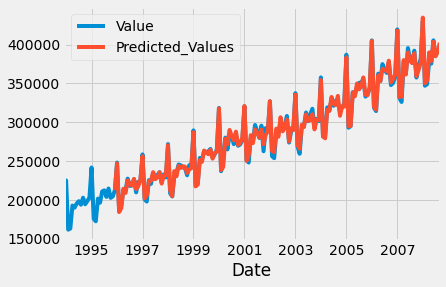

In [37]:
df_c_arima.iloc[:,:][['Value','Predicted_Values']].plot()

In [38]:
def show_prediction(y, y_pred, name='', pred_title='pred'):
    plt.figure(figsize= (15,6.5))
    plt.title(name)
    plt.plot(y, label='y', marker='o')
    plt.plot(y_pred, label=pred_title, marker='o')
    plt.legend()
    plt.show()

## Plot after come back

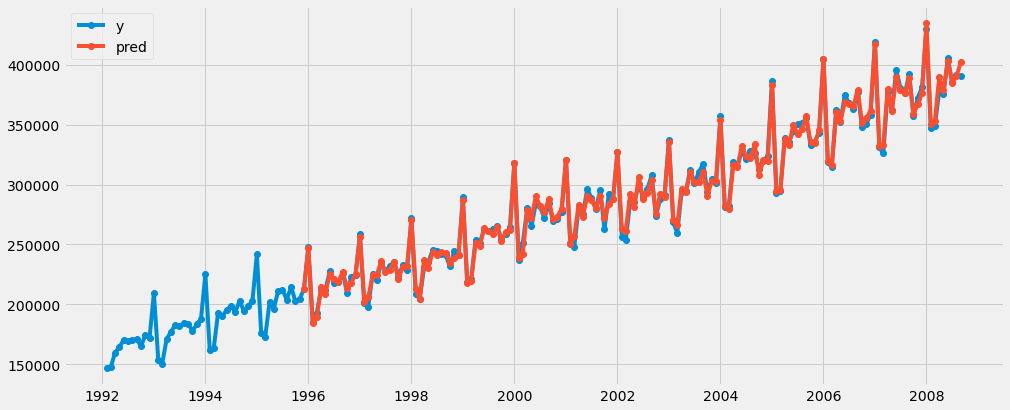

In [39]:
show_prediction(y, df_c_arima.Predicted_Values)

## metrics for ARIMA model

In [40]:
predictions = df_c_arima.Predicted_Values.dropna()[df_test_lag.index]
values = y.Value[df_test_lag.index]
name = f'ARIMA_test{best_p_arima,diff_model,best_q_arima}'
parametrs = best_p_arima+best_q_arima + diff_model
metrics = claculate_metrics_model(values, predictions, name=name, count_parameters=parametrs)
models_metrics_static_test = models_metrics_static_test.append(metrics)

In [41]:
predictions = df_c_arima.Predicted_Values.dropna()
values = y.Value[df_c_arima.Predicted_Values.dropna().index]
name = f'ARIMA{best_p_arima,diff_model,best_q_arima}'
parametrs = best_p_arima+best_q_arima + diff_model
metrics = claculate_metrics_model(values, predictions, name=name, count_parameters=parametrs)
models_metrics_static = models_metrics_static.append(metrics)

# ====================================================

# Fiting ARMA model on detrended values

usnig only detrending values

In [42]:
calculate_metrics_sample(y_detrend.Value.dropna())

yes


,series,observations,mode,mean,median,variation,skewness,kurtosis,jarque-bera,probability
0,Y,191,-1.5139975973039137,0.29430675771472503,0.3547550682481003,0.9700530694941747,0.36764637130392375,0.8640800289136732,9.461555070875926,0.008819610813081469


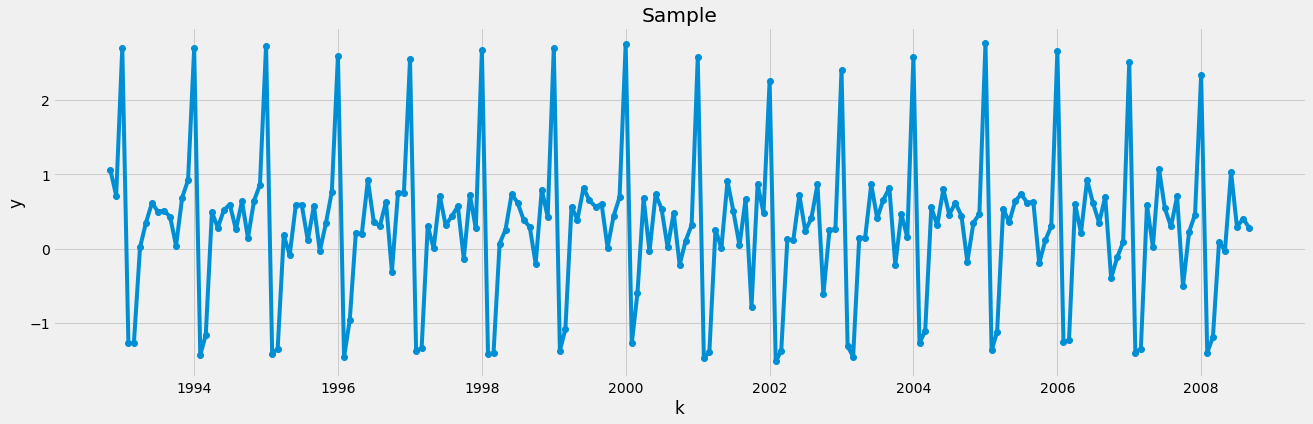

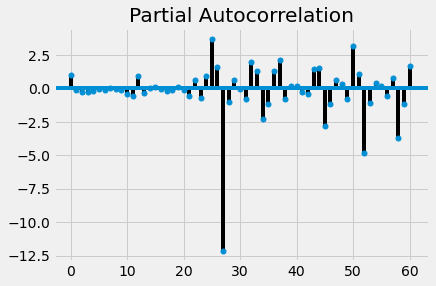

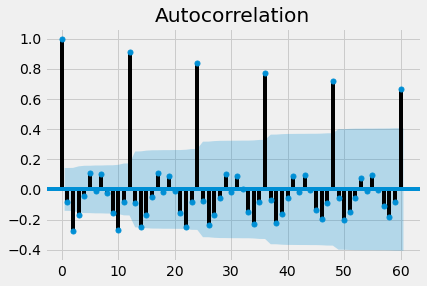

In [43]:
show_plots(y_detrend.Value.dropna())

## Choosing AR model

In [44]:
models_metrics_ar = pd.DataFrame(columns=columns)

best_RMSE = 1e15
best_p = -1

for i in range(1, 50):
    df_train, df_test, theta, intercept, RMSE = AR(i, pd.DataFrame(y_detrend.Value))
    metric = claculate_metrics_model(df_test.Value, df_test.Predicted_Values, f'AR({i})', i)
    models_metrics_ar = models_metrics_ar.append(metric)
        
    if RMSE < best_RMSE:
        best_RMSE = RMSE
        best_p = i
        
print(f'best_p:\t{best_p}')

best_p:	37


In [45]:
models_metrics_ar

,name,r2,RMSE,MAE,sum_squared_resid,AIC,durbin_watson,theil_index
0,AR(1),-0.02744808,0.92173308,0.64903952,16.99183724,-1.25998414,1.57913487,0.74058840
0,AR(2),0.07846522,0.87293337,0.68280567,15.24025342,-1.43584190,1.63211169,0.63664485
0,AR(3),0.11013932,0.85780039,0.65387128,14.71643021,-0.13535405,1.66580173,0.59239579
0,AR(4),0.16371507,0.83157680,0.61785364,13.83039958,0.62273528,1.45989694,0.55488526
0,AR(5),0.14872253,0.83899776,0.62133833,14.07834475,2.97811020,1.46763342,0.55616997
0,AR(6),0.16617535,0.83035269,0.60651459,13.78971172,4.56381026,1.33471794,0.53478172
0,AR(7),0.17167240,0.82761108,0.60980536,13.69880197,6.43152216,1.33905671,0.53451799
0,AR(8),0.17166860,0.82761298,0.61652750,13.69886492,8.43161406,1.32668154,0.53158862
0,AR(9),0.18437246,0.82124204,0.60716390,13.48876969,10.12250381,1.45481669,0.51991359
0,AR(10),0.37785002,0.71725366,0.59242361,10.28905636,6.70697135,1.66332580,0.42992164


In [46]:
best_p_ar = 12
df_train_ar,df_test_ar,theta_ar,intercept_ar,RMSE = AR(best_p_ar,pd.DataFrame(y_detrend.Value))

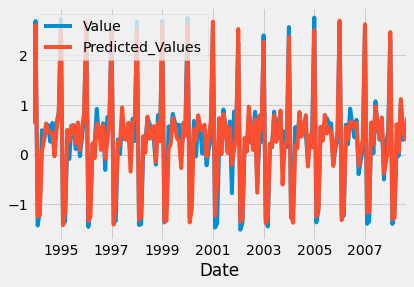

In [47]:
df_c_ar = pd.concat([df_train_ar,df_test_ar])
df_c_ar[['Value','Predicted_Values']].plot()

In [48]:
predictions = df_c_ar.Predicted_Values.dropna()[df_test.index] * y.rolling(window=rolling_value).std().Value[df_test.index]
predictions += y.rolling(window=rolling_value).mean().Value[df_test.index]


# predictions = df_c_ar.Predicted_Values[df_test.index]
values = y.Value[df_test.index]
name = f'AR_test({best_p_ar})'
parametrs = best_p_ar
metrics = claculate_metrics_model(values, predictions, name=name, count_parameters=parametrs)
models_metrics_static_test = models_metrics_static_test.append(metrics)

In [49]:
metrics

,name,r2,RMSE,MAE,sum_squared_resid,AIC,durbin_watson,theil_index
0,AR_test(12),0.95050121,5366.04947018,4271.11825632,575889738.32772684,367.51389001,1.65961180,0.00711551


In [52]:
predictions = df_c_ar.Predicted_Values.dropna() * y.rolling(window=rolling_value).std().Value[df_c_ar.Predicted_Values.dropna().index]
predictions += y.rolling(window=rolling_value).mean().Value[df_c_ar.Predicted_Values.dropna().index]

values = y.Value[df_c_ar.Predicted_Values.dropna().index]
name = f'AR({best_p_ar})'
parametrs = best_p_ar 
metrics = claculate_metrics_model(values, predictions, name=name, count_parameters=parametrs)
models_metrics_static = models_metrics_static.append(metrics)

## Choosing ma

In [53]:
res_ma = pd.DataFrame()
res_ma['Residuals'] = df_c_ar.Value - df_c_ar.Predicted_Values

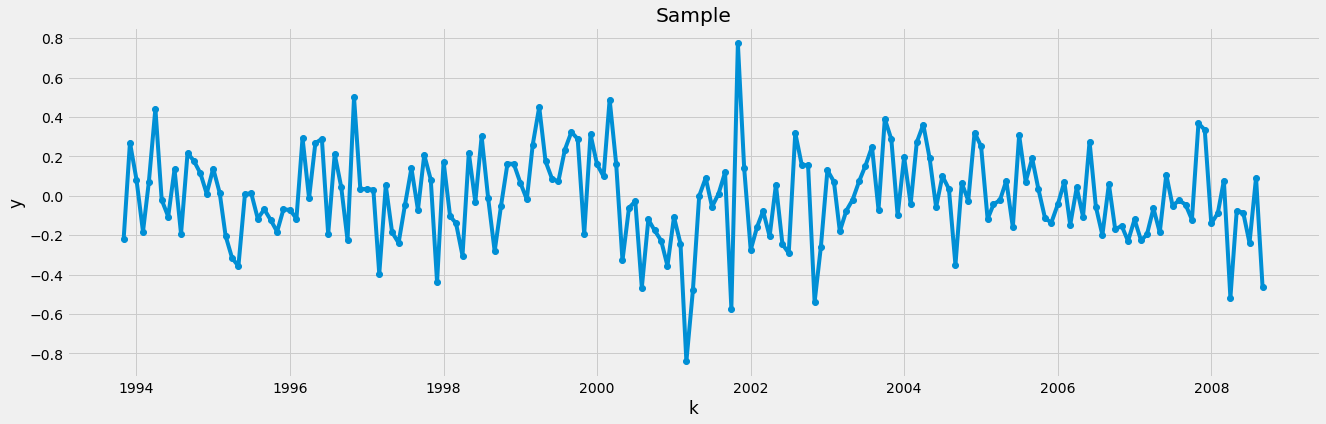

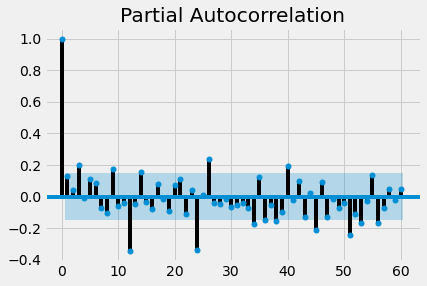

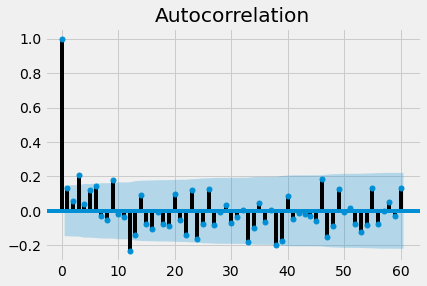

In [54]:
show_plots(res_ma.Residuals)

In [55]:
models_metrics_ma = pd.DataFrame(columns=columns)


best_RMSE=100000000000
best_q = -1

for i in range(1,50):
    
    res_train, res_test,theta,intercept,RMSE = MA(i,pd.DataFrame(res.Residuals))
    metric = claculate_metrics_model(res_test.Residuals, res_test.Predicted_Values, f'MA({i})', i)
    models_metrics_ma = models_metrics_ma.append(metric)
    
    
    if(RMSE<best_RMSE):
        best_RMSE = RMSE
        best_q = i

In [56]:
print(f'best_q:\t {best_q}')

best_q:	 26


In [57]:
models_metrics_ma

,name,r2,RMSE,MAE,sum_squared_resid,AIC,durbin_watson,theil_index
0,MA(1),-0.01846081,0.22289590,0.16065719,0.89428651,-52.03781495,2.12696253,0.97877255
0,MA(2),-0.01812143,0.22285876,0.16063439,0.89398851,-50.04381398,2.12455479,0.97856535
0,MA(3),0.05812365,0.21435167,0.15588419,0.82703950,-49.44494253,1.99862977,0.82521045
0,MA(4),0.04908802,0.21537738,0.15611897,0.83497347,-47.27308743,2.00432674,0.82850760
0,MA(5),0.08241123,0.21156994,0.14957687,0.80571314,-45.91518667,1.97188093,0.79407249
0,MA(6),0.05727811,0.21444786,0.15468651,0.82778194,-43.42879089,1.88131502,0.78216243
0,MA(7),0.06784867,0.21324219,0.15408633,0.81850019,-41.63176145,1.89424072,0.77543122
0,MA(8),0.07494185,0.21242931,0.15100292,0.81227183,-39.76925580,1.92726229,0.75357350
0,MA(9),0.02558899,0.21802235,0.14453713,0.85560742,-36.83367698,1.76245749,0.77092951
0,MA(10),0.02902070,0.21763809,0.14441433,0.85259411,-34.89718192,1.77580473,0.77120355


In [58]:
best_q_arma=24
res_train_ma, res_test_ma,theta_ma,intercept_ma,RMSE = MA(best_q_arma,pd.DataFrame(res_ma.Residuals))

In [59]:
res_c_ma = pd.concat([res_train_ma,res_test_ma])
df_c_arma = df_c_ar
df_c_arma.Predicted_Values += res_c_ma.Predicted_Values

## detrended come back to real value

In [60]:
df_c_arma.Value *= y.rolling(window=rolling_value).std().Value
df_c_arma.Value += y.rolling(window=rolling_value).mean().Value

df_c_arma.Predicted_Values *= y.rolling(window=rolling_value).std().Value
df_c_arma.Predicted_Values += y.rolling(window=rolling_value).mean().Value

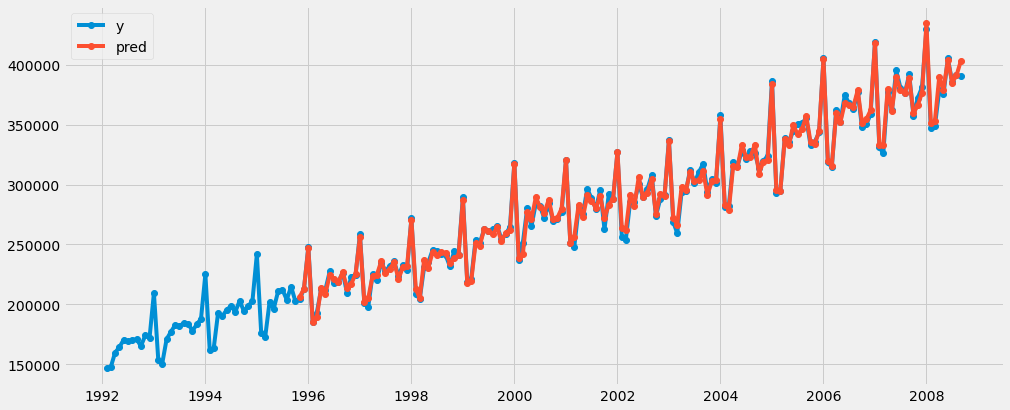

In [61]:
show_prediction(y, df_c_arma.Predicted_Values)

In [62]:
predictions = df_c_arma.Predicted_Values.dropna()[df_test.index]
values = y.Value[df_test.index]
name = f'ARMA_test{best_p_ar,best_q_arma}'
parametrs = best_p_ar+best_q_arma
metrics = claculate_metrics_model(values, predictions, name=name, count_parameters=parametrs)
models_metrics_static_test = models_metrics_static_test.append(metrics)

In [63]:
predictions = df_c_arma.Predicted_Values.dropna()
values = y.Value[df_c_arma.Predicted_Values.dropna().index]
name = f'ARMA{best_p_ar, best_q_arma}'
parametrs = best_p_ar + best_q_arma
metrics = claculate_metrics_model(values, predictions, name=name, count_parameters=parametrs)
models_metrics_static = models_metrics_static.append(metrics)

# ================================================

# Linear regression model 

In [64]:
from sklearn.preprocessing import PolynomialFeatures

def trend_equal(y, trend=1):   
    
    df_temp = y
    
    date_start = np.array(str(df_temp.index[0])[:7], dtype=np.datetime64)
    date_start = date_start + np.arange(len(y))
    y_new = df_temp.values

    X = np.array([x for x in range(1, len(df_temp))])
    X = np.reshape(X, (len(X), 1))
    
    train_size = (int)(precent_train_set * df_temp.shape[0])
    df_train = pd.DataFrame(y[:train_size])
    df_test = pd.DataFrame(y[train_size:])
    
    x_train = pd.DataFrame(X[:train_size])
    y_train = pd.DataFrame(y_new[:train_size])

    x_test = pd.DataFrame(X[train_size - 1:])
    y_test = pd.DataFrame(y_new[train_size:])

    
    if trend != 1:
        pf = PolynomialFeatures(degree=trend)
        x_train = pf.fit_transform(x_train)
        x_test = pf.fit_transform(x_test)

    model = LinearRegression()
    model.fit(x_train, y_train)
    
    pred_train = model.predict(x_train)
    pred_test = model.predict(x_test)
    
    pred_train = np.reshape(pred_train, (len(pred_train), ))
    pred_test = np.reshape(pred_test, (len(pred_test, )))
    
    train_df = pd.DataFrame({'Date': date_start[:train_size], 'Value': pred_train}).set_index('Date')
    test_df = pd.DataFrame({'Date': date_start[train_size :], 'Value': pred_test}).set_index('Date')
    
    df_train['Predicted_Values'] = train_df.Value
    df_test['Predicted_Values'] = test_df.Value  
        
    RMSE = np.sqrt(mean_squared_error(df_test['Value'], df_test['Predicted_Values']))
    
    return df_train, df_test, model.coef_, model.intercept_, RMSE

In [65]:
models_metrics_trend = pd.DataFrame(columns=columns)

best_RMSE = 1e15
best_t = -1

for i in range(1, 6):
#     print(i)
    df_train, df_test, theta, intercept, RMSE = trend_equal(pd.DataFrame(y.Value), i)
    metric = claculate_metrics_model(df_test.Value, df_test.Predicted_Values, f'trend({i})', i)
    models_metrics_trend = models_metrics_trend.append(metric)
    
    print(f'\ntrend:\t {i}')
    print(f'theta:\n {theta}')
    print(f'intercept:\n {intercept}')
    
    if RMSE < best_RMSE:
        best_RMSE = RMSE
        best_t = i
        
print(f'best_trend:\t{best_t}')


trend:	 1
theta:
 [[1108.0066072]]
intercept:
 [156728.46871508]

trend:	 2
theta:
 [[  0.         890.89896269   1.19948975]]
intercept:
 [163314.06726508]

trend:	 3
theta:
 [[ 0.00000000e+00  1.43675596e+03 -6.31912536e+00  2.76928733e-02]]
intercept:
 [154966.90077346]

trend:	 4
theta:
 [[ 0.00000000e+00  8.27368181e+02  8.73366238e+00 -1.01434247e-01
   3.56704754e-04]]
intercept:
 [160619.25969469]

trend:	 5
theta:
 [[ 0.00000000e+00  1.99069484e+03 -3.57594084e+01  5.51334816e-01
  -3.69487270e-03  8.95376231e-06]]
intercept:
 [153328.11795619]
best_trend:	2


In [66]:
models_metrics_trend

,name,r2,RMSE,MAE,sum_squared_resid,AIC,durbin_watson,theil_index
0,trend(1),0.04051668,23625.23362511,19383.53069056,11163033276.81848717,404.80282565,1.55882302,0.03180527
0,trend(2),0.18424156,21784.02793867,16412.63226965,9490877464.65920448,403.55729268,1.83181779,0.02899160
0,trend(3),-0.13235516,25665.44086224,20923.92741287,13174297093.06775856,412.11602610,1.31756685,0.03353614
0,trend(4),-1.07664705,34756.71650899,29879.65920091,24160586849.72610855,426.24512453,0.71843803,0.04466847
0,trend(5),-4.61373012,57145.64800694,49393.93519880,65312501722.66546631,448.13434064,0.26815164,0.07128310


In [67]:
best_t = 2
df_train_trend, df_test_trend, theta_trend, intercept_trend, RMSE = trend_equal(pd.DataFrame(y.Value), best_t)

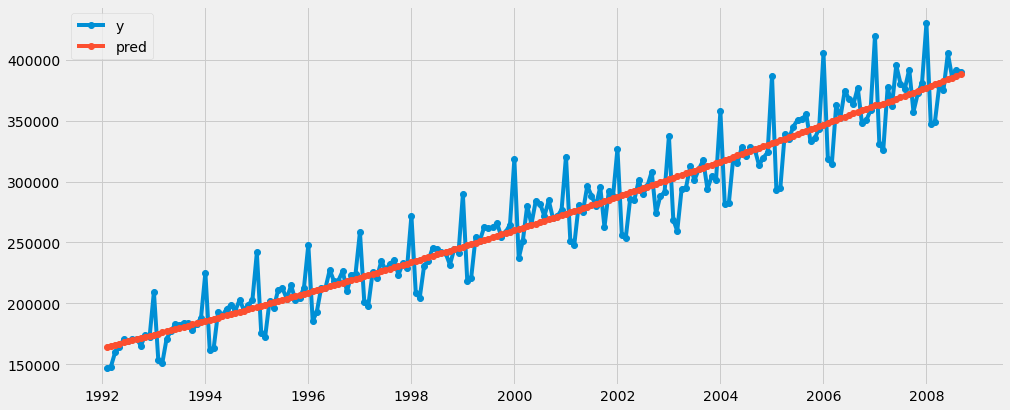

In [68]:
df_c = pd.concat([df_train_trend,df_test_trend])
show_prediction(y, df_c.Predicted_Values)

## Calculate metrix for LR

In [69]:
predictions = df_c.Predicted_Values.dropna()[df_test.index]
values = y.Value[df_test.index]
name = f'LR({best_t})'
parametrs = best_t
metrics = claculate_metrics_model(values, predictions, name=name, count_parameters=parametrs)
models_metrics_static_test = models_metrics_static_test.append(metrics)

In [70]:
predictions = df_c.Predicted_Values.dropna()
values = y.Value[df_c.Predicted_Values.dropna().index]
name = f'LR({best_t})'
parametrs = best_t
metrics = claculate_metrics_model(values, predictions, name=name, count_parameters=parametrs)
models_metrics_static = models_metrics_static.append(metrics)

## Metrics for static_prediction 

In [71]:
models_metrics_static_test

,name,r2,RMSE,MAE,sum_squared_resid,AIC,durbin_watson,theil_index
0,"ARIMA_test(12, 1, 24)",0.95794189,4946.32065700,3815.33439519,489321760.83778363,414.25597110,1.19632795,0.00656547
0,AR_test(12),0.95050121,5366.04947018,4271.11825632,575889738.32772684,367.51389001,1.65961180,0.00711551
0,"ARMA_test(12, 24)",0.95461607,5138.16996310,3888.78912880,528015811.39468265,413.77809027,1.12646200,0.00681796
0,LR(2),0.18424156,21784.02793867,16412.63226965,9490877464.65920448,403.55729268,1.83181779,0.02899160


In [72]:
models_metrics_static

,name,r2,RMSE,MAE,sum_squared_resid,AIC,durbin_watson,theil_index
0,"ARIMA(12, 1, 24)",0.99529110,3856.41045255,3006.11373351,2290272843.09012747,2617.30756533,1.82657084,0.00644292
0,AR(12),0.99471372,4531.92461516,3510.63592316,3676362988.42495060,3037.96691174,1.70936956,0.00788584
0,"ARMA(12, 24)",0.99532227,3862.33072800,3017.73040780,2312227791.12939262,2632.29808969,1.76884825,0.00646360
0,LR(2),0.91981677,19271.87936434,13365.52169454,74281066846.73387146,3950.56091386,2.13892852,0.03479046


## Plots for static prediction

In [73]:
def plot_all_grafics(df_y, df_ar, df_arma, df_arima, df_lr, period, name='All models prediction'):
    plt.figure(figsize= (15,6.5))
    plt.title(name)
    
    plt.plot(df_y.Value[period], label='y', marker='o')
    plt.plot(df_ar.Predicted_Values[period], label='pred_AR', marker='o')
    plt.plot(df_arma.Predicted_Values[period], label='pred_ARMA', marker='o')
    plt.plot(df_arima.Predicted_Values[period], label='pred_ARIMA', marker='o')
    plt.plot(df_lr.Predicted_Values[period], label='pred_LR', marker='o')
    plt.legend()
    plt.show()

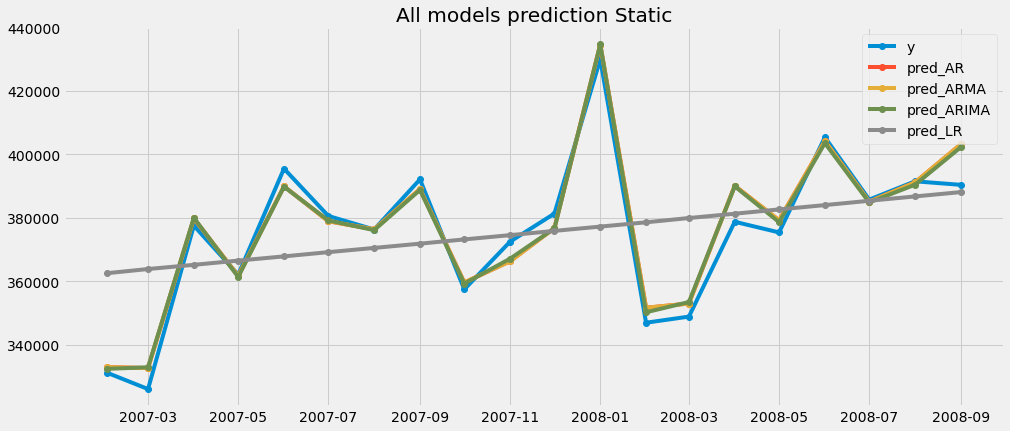

In [74]:
df_y = y
df_ar = df_c_ar
df_arma = df_c_arma
df_arima = df_c_arima
df_lr = df_test_trend
period = df_test_trend.Predicted_Values.index
name='All models prediction Static'
plot_all_grafics(df_y, df_ar, df_arma, df_arima, df_lr, period, name)

# Dinamic prediction

In [75]:
def dinamic_prediction_arma(p,q, df_y, df_res, coef_ar, coef_ma, intercept_ar, intercept_ma, period_predict):
    
    print(f'p:\t{p}\nq:\t{q}')
    print(f'len_coef_ar:\t{len(coef_ar)}')
    print(f'len_coef_ma:\t{len(coef_ma)}')
    print(f'preriod:\t{period_predict.shape[0]}')
    
    df_temp_y = df_y
    df_temp_res = df_res
   
    y_predict = np.array(df_temp_y.Value[-p:])
    res_predict = np.array(df_temp_res.Residuals[-q:])
    
    y_result = np.array([])
    
    coef_ar = coef_ar[::-1]
    coef_ma = coef_ma[::-1]
    
    for i in range(period_predict.shape[0]):
        
        y_temp = np.dot(y_predict, coef_ar) + intercept_ar
        res_temp = np.dot(res_predict, coef_ma) + intercept_ma
        y_temp += res_temp 
        y_result = np.append(y_result, y_temp)
        
        y_predict = np.delete(y_predict, 0)
        res_predict = np.delete(res_predict, 0)

        y_predict = np.append(y_predict, y_temp)
        res_predict = np.append(res_predict, res_temp)

    
    return pd.DataFrame({'Date': period_predict, 'Predicted_Values':y_result}).set_index('Date')

### Dinamic ARIMA

In [76]:
models_metrics_dinamic_test_before = pd.DataFrame(columns=columns)
models_metrics_dinamic_test_after = pd.DataFrame(columns=columns)

In [77]:
# arima prediction
p = best_p_arima
q = best_q_arima
df_y = df_train_lag
df_res = res_train_lag

coef_ar = theta_ar_lag
coef_ma = theta_ma_lag
intercept_ar = intercept_ar_lag 
intercept_ma =  intercept_ma_lag
period_predict = df_test_trend.Predicted_Values.index

y_dinamic_arima = dinamic_prediction_arma(p=p,q=q, df_y=df_y, df_res=df_res, coef_ar=coef_ar, coef_ma=coef_ma, 
                        intercept_ar=intercept_ar, intercept_ma=intercept_ma, period_predict=period_predict)

p:	12
q:	24
len_coef_ar:	12
len_coef_ma:	24
preriod:	20


In [78]:
predictions = y_dinamic_arima.Predicted_Values
values = y_10lag_detrend.Value[y_dinamic_arima.Predicted_Values.index]
name = f'ARIMA_din_after({p,diff_model,q})'
parametrs = p + q +diff_model
metrics = claculate_metrics_model(values, predictions, name=name, count_parameters=parametrs)
models_metrics_dinamic_test_before = models_metrics_dinamic_test_before.append(metrics)

In [79]:
#come back
y_dinamic_arima.Predicted_Values += y_detrend.shift(diff_model).Value[df_test_trend.Predicted_Values.index]
y_dinamic_arima.Predicted_Values *= y.rolling(window=rolling_value).std().Value[df_test_trend.Predicted_Values.index]
y_dinamic_arima.Predicted_Values += y.rolling(window=rolling_value).mean().Value[df_test_trend.Predicted_Values.index]

In [80]:
predictions = y_dinamic_arima.Predicted_Values
values = y.Value[y_dinamic_arima.Predicted_Values.index]
name = f'ARIMA_dinam({p,diff_model,q})'
parametrs = p + q +diff_model
metrics = claculate_metrics_model(values, predictions, name=name, count_parameters=parametrs)
models_metrics_dinamic_test_after = models_metrics_dinamic_test_after.append(metrics)

#### Dinamic ARMA

In [81]:
# arima prediction
p = best_p_ar
q = best_q_arma
df_y = df_train_ar
df_res = res_train_ma

coef_ar = theta_ar
coef_ma = theta_ma
intercept_ar = intercept_ar 
intercept_ma =  intercept_ma
period_predict = df_test_trend.Predicted_Values.index

y_dinamic_arma = dinamic_prediction_arma(p=p,q=q, df_y=df_y, df_res=df_res, coef_ar=coef_ar, coef_ma=coef_ma, 
                        intercept_ar=intercept_ar, intercept_ma=intercept_ma, period_predict=period_predict)

p:	12
q:	24
len_coef_ar:	12
len_coef_ma:	24
preriod:	20


In [82]:
predictions = y_dinamic_arma.Predicted_Values
values = y_detrend.Value[y_dinamic_arma.Predicted_Values.index]
name = f'ARMA_din_after({p,q})'
parametrs = p + q
metrics = claculate_metrics_model(values, predictions, name=name, count_parameters=parametrs)
models_metrics_dinamic_test_before = models_metrics_dinamic_test_before.append(metrics)

In [83]:
# come back arma 
y_dinamic_arma.Predicted_Values *= y.rolling(window=rolling_value).std().Value[df_test_trend.Predicted_Values.index]
y_dinamic_arma.Predicted_Values += y.rolling(window=rolling_value).mean().Value[df_test_trend.Predicted_Values.index]

In [84]:
predictions = y_dinamic_arma.Predicted_Values
values = y.Value[y_dinamic_arma.Predicted_Values.index]
name = f'ARMA_din({p,q})'
parametrs = p + q
metrics = claculate_metrics_model(values, predictions, name=name, count_parameters=parametrs)
models_metrics_dinamic_test_after = models_metrics_dinamic_test_after.append(metrics)

### Dinamic AR

In [85]:
def dinamic_prediction_ar(p, df_y, coef_ar, intercept_ar, period_predict):
    
    print(f'p:\t{p}')
    
    df_temp_y = df_y
    y_predict = np.array(df_temp_y.Value[-p:])
    y_result = np.array([])
    coef_ar = coef_ar[::-1]
    
    for i in range(period_predict.shape[0]):
        
        y_temp = np.dot(y_predict, coef_ar) + intercept_ar
        y_result = np.append(y_result, y_temp)
        
        y_predict = np.delete(y_predict, 0)

        y_predict = np.append(y_predict, y_temp)

    
    return pd.DataFrame({'Date': period_predict, 'Predicted_Values':y_result}).set_index('Date')

In [86]:
# ar prediction
p = best_p_ar
df_y = df_train_ar

coef_ar = theta_ar
intercept_ar = intercept_ar 
period_predict = df_test_trend.Predicted_Values.index

y_dinamic_ar = dinamic_prediction_ar(p=p,df_y=df_y, coef_ar=coef_ar, intercept_ar=intercept_ar, 
                                         period_predict=period_predict)

p:	12


In [87]:
predictions = y_dinamic_ar.Predicted_Values
values = y_detrend.Value[df_test_trend.Predicted_Values.index]
name = f'AR_din_after({p})'
parametrs = p 
metrics = claculate_metrics_model(values, predictions, name=name, count_parameters=parametrs)
models_metrics_dinamic_test_before = models_metrics_dinamic_test_before.append(metrics)

In [88]:
# come back ar 
y_dinamic_ar.Predicted_Values *= y.rolling(window=rolling_value).std().Value[df_test_trend.Predicted_Values.index]
y_dinamic_ar.Predicted_Values += y.rolling(window=rolling_value).mean().Value[df_test_trend.Predicted_Values.index]

In [89]:
predictions = y_dinamic_ar.Predicted_Values
values = y.Value[df_test_trend.Predicted_Values.index]
name = f'AR_din({p})'
parametrs = p 
metrics = claculate_metrics_model(values, predictions, name=name, count_parameters=parametrs)
models_metrics_dinamic_test_after = models_metrics_dinamic_test_after.append(metrics)

## comparing all metrics

###  Dinamic metrics on test set after come back to real values

In [90]:
models_metrics_dinamic_test_after

,name,r2,RMSE,MAE,sum_squared_resid,AIC,durbin_watson,theil_index
0,"ARIMA_dinam((12, 1, 24))",0.91527534,7020.40737038,5458.36822732,985722392.92225993,428.26306101,2.34513679,0.00932513
0,"ARMA_din((12, 24))",0.95255990,5253.27578836,4398.51970167,551938130.17117929,414.66428483,1.73376824,0.00699860
0,AR_din(12),0.95477775,5129.00936877,3994.58252434,526134742.09851259,365.70671256,1.93045934,0.00683020


###  Static metrics on test set after come back to real value

In [91]:
models_metrics_static_test

,name,r2,RMSE,MAE,sum_squared_resid,AIC,durbin_watson,theil_index
0,"ARIMA_test(12, 1, 24)",0.95794189,4946.32065700,3815.33439519,489321760.83778363,414.25597110,1.19632795,0.00656547
0,AR_test(12),0.95050121,5366.04947018,4271.11825632,575889738.32772684,367.51389001,1.65961180,0.00711551
0,"ARMA_test(12, 24)",0.95461607,5138.16996310,3888.78912880,528015811.39468265,413.77809027,1.12646200,0.00681796
0,LR(2),0.18424156,21784.02793867,16412.63226965,9490877464.65920448,403.55729268,1.83181779,0.02899160


## plot for Dinamic predictions

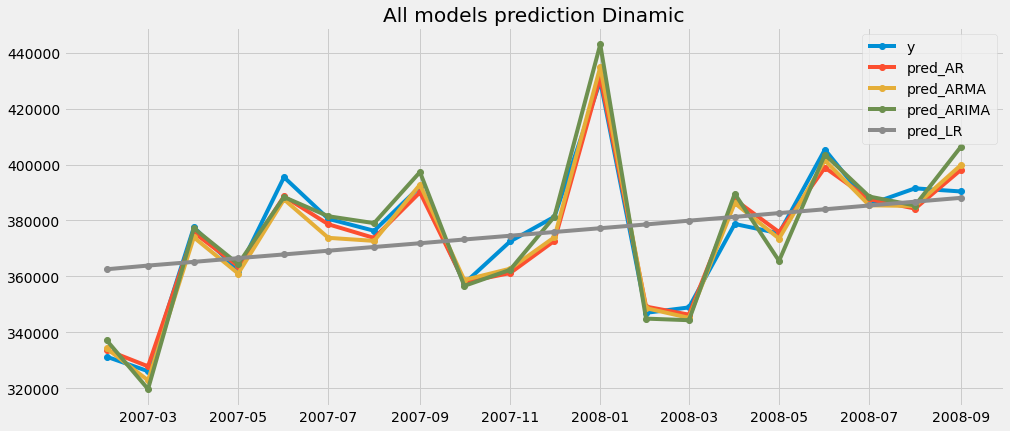

In [92]:
df_y = y
df_ar = y_dinamic_ar
df_arma = y_dinamic_arma
df_arima = y_dinamic_arima
df_lr = df_test_trend
period = df_test_trend.Predicted_Values.index
name='All models prediction Dinamic'
plot_all_grafics(df_y, df_ar, df_arma, df_arima, df_lr, period, name)